In [1]:
from braindecode.datasets import BaseConcatDataset, BaseDataset
import os

import numpy as np
import pandas as pd
import mne
from mne.datasets.sleep_physionet.age import fetch_data


from braindecode.datautil.preprocess import preprocess, Preprocessor
from braindecode.datautil.windowers import create_windows_from_events
from braindecode.datautil.preprocess import zscore

import numpy as np
import copy
from tqdm import tqdm
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from scipy.interpolate import interp1d
from sklearn.metrics import (
    cohen_kappa_score,
    accuracy_score,
    f1_score,
    confusion_matrix,
)
from sklearn.linear_model import LogisticRegression as LR

import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import mne
from mne.datasets.sleep_physionet.age import fetch_data

from braindecode.datautil.preprocess import preprocess, Preprocessor
from braindecode.datautil.windowers import create_windows_from_events
from braindecode.datautil.preprocess import zscore
from braindecode.datasets import BaseConcatDataset, BaseDataset

from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler
from sklearn.utils import check_random_state

PATH = '/home/likith012/test'


# Params
NEG_SAMPLES = 128 # number of negative samples per positive sample
BATCH_SIZE = 1
POS_MIN = 1
NEG_MIN = 15
EPOCH_LEN = 7
NUM_SAMPLES = 2000
SUBJECTS = np.arange(6)
RECORDINGS = [1, 2]

/anaconda/envs/torch/lib/python3.8/site-packages/braindecode/datautil/preprocess.py:10: UserWarning: datautil.preprocess module is deprecated and is now under preprocessing.preprocess, please use from import braindecode.preprocessing.preprocess
  warn('datautil.preprocess module is deprecated and is now under '
/anaconda/envs/torch/lib/python3.8/site-packages/braindecode/datautil/windowers.py:4: UserWarning: datautil.windowers module is deprecated and is now under preprocessing.windowers, please use from import braindecode.preprocessing.windowers
  warn('datautil.windowers module is deprecated and is now under '


In [2]:
random_state = 1234
n_jobs = 1
sfreq = 100
high_cut_hz = 30

window_size_s = 30
sfreq = 100
window_size_samples = window_size_s * sfreq



class SleepPhysionet(BaseConcatDataset):
    def __init__(
        self,
        subject_ids=None,
        recording_ids=None,
        preload=False,
        load_eeg_only=True,
        crop_wake_mins=30,
        crop=None,
    ):
        if subject_ids is None:
            subject_ids = range(83)
        if recording_ids is None:
            recording_ids = [1, 2]

        paths = fetch_data(
            subject_ids,
            recording=recording_ids,
            on_missing="warn",
            path='/home/likith012/test/',
        )

        all_base_ds = list()
        for p in paths:
            raw, desc = self._load_raw(
                p[0],
                p[1],
                preload=preload,
                load_eeg_only=load_eeg_only,
                crop_wake_mins=crop_wake_mins,
                crop=crop,
            )
            base_ds = BaseDataset(raw, desc)
            all_base_ds.append(base_ds)
        super().__init__(all_base_ds)

    @staticmethod
    def _load_raw(
        raw_fname,
        ann_fname,
        preload,
        load_eeg_only=True,
        crop_wake_mins=False,
        crop=None,
    ):
        ch_mapping = {
            "EOG horizontal": "eog",
            "Resp oro-nasal": "misc",
            "EMG submental": "misc",
            "Temp rectal": "misc",
            "Event marker": "misc",
        }
        exclude = list(ch_mapping.keys()) if load_eeg_only else ()

        raw = mne.io.read_raw_edf(raw_fname, preload=preload, exclude=exclude)
        annots = mne.read_annotations(ann_fname)
        raw.set_annotations(annots, emit_warning=False)

        if crop_wake_mins > 0:
            # Find first and last sleep stages
            mask = [x[-1] in ["1", "2", "3", "4", "R"] for x in annots.description]
            sleep_event_inds = np.where(mask)[0]

            # Crop raw
            tmin = annots[int(sleep_event_inds[0])]["onset"] - crop_wake_mins * 60
            tmax = annots[int(sleep_event_inds[-1])]["onset"] + crop_wake_mins * 60
            raw.crop(tmin=max(tmin, raw.times[0]), tmax=min(tmax, raw.times[-1]))

        # Rename EEG channels
        ch_names = {i: i.replace("EEG ", "") for i in raw.ch_names if "EEG" in i}
        raw.rename_channels(ch_names)

        if not load_eeg_only:
            raw.set_channel_types(ch_mapping)

        if crop is not None:
            raw.crop(*crop)

        basename = os.path.basename(raw_fname)
        subj_nb = int(basename[3:5])
        sess_nb = int(basename[5])
        desc = pd.Series({"subject": subj_nb, "recording": sess_nb}, name="")
       

        return raw, desc


random_state = 1234
n_jobs = -1
sfreq = 100
high_cut_hz = 30

EPOCH_LEN = 15

dataset = SleepPhysionet(
    subject_ids=SUBJECTS, recording_ids=RECORDINGS, crop_wake_mins=30
)

preprocessors = [
    Preprocessor(lambda x: x * 1e6),
    Preprocessor("filter", l_freq=None, h_freq=high_cut_hz, n_jobs=n_jobs),
]

# Transform the data
preprocess(dataset, preprocessors)


mapping = {  # We merge stages 3 and 4 following AASM standards.
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
}

windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=0,
    trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples,
    preload= True,
    mapping=mapping,
)


preprocess(windows_dataset, [Preprocessor(zscore)])


Extracting EDF parameters from /home/likith012/test/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/likith012/test/physionet-sleep-data/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/likith012/test/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/likith012/test/physionet-sleep-data/SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/likith012/test/physionet-sleep-data/SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/likith012/test/physionet-sleep-data/SC4022E0-PSG.edf...
EDF file detected
Setting c

/anaconda/envs/torch/lib/python3.8/site-packages/braindecode/preprocessing/preprocess.py:52: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3348000  =      0.000 ... 33480.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.5s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3261000  =      0.000 ... 32610.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.7s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3447000  =      0.000 ... 34470.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.6s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3060000  =      0.000 ... 30600.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3027000  =      0.000 ... 30270.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.9s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2850000  =      0.000 ... 28500.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.8s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2706000  =      0.000 ... 27060.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.8s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3705000  =      0.000 ... 37050.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.8s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3606000  =      0.000 ... 36060.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2010000  =      0.000 ... 20100.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3741000  =      0.000 ... 37410.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.6s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
837 matching events found
No baseline correction applied
0 projection items activated
Loading data for 837 events and 3000 original time points ...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s finished


0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1116 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1116 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1088 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1088 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1150 matching

/anaconda/envs/torch/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function zscore is deprecated; will be removed in 0.7.0. Use sklearn.preprocessing.scale instead.
  warnings.warn(msg, category=FutureWarning)


In [3]:
class RecordingSampler(Sampler):
    def __init__(self, metadata, random_state=None, epoch_len=7):

        self.metadata = metadata
        self._init_info()
        self.rng = check_random_state(random_state)
        self.epoch_len = epoch_len

    def _init_info(self):
        keys = ["subject", "recording"]

        self.metadata = self.metadata.reset_index().rename(
            columns={"index": "window_index"}
        )
        self.info = (
            self.metadata.reset_index()
            .groupby(keys)[["index", "i_start_in_trial"]]
            .agg(["unique"])
        )
        self.info.columns = self.info.columns.get_level_values(0)

    def sample_recording(self):
        """Return a random recording index."""
        return self.rng.choice(self.n_recordings)

    def sample_window(self, rec_ind=None):
        """Return a specific window."""
        if rec_ind is None:
            rec_ind = self.sample_recording()
        win_ind = self.rng.choice(
            self.info.iloc[rec_ind]["index"][self.epoch_len // 2 : -self.epoch_len // 2]
        )
        return win_ind, rec_ind

    def __iter__(self):
        raise NotImplementedError

    @property
    def n_recordings(self):
        return self.info.shape[0]


class RelativePositioningSampler(RecordingSampler):
    def __init__(
        self,
        metadata,
        tau_pos,
        tau_neg,
        n_examples,
        same_rec_neg=True,
        random_state=None,
        epoch_len=7,
        neg_samples = NEG_SAMPLES
    ):
        super().__init__(metadata, random_state=random_state, epoch_len=epoch_len)

        self.tau_pos = tau_pos
        self.tau_neg = tau_neg
        self.neg_samples = neg_samples
        self.n_examples = n_examples
        self.same_rec_neg = same_rec_neg

    def _sample_pair(self):
        
        """Sample a pair of two windows."""
        # Sample first window
        win_ind1, rec_ind1 = self.sample_window()
        
        ts1 = self.metadata.iloc[win_ind1]["i_start_in_trial"]
        ts = self.info.iloc[rec_ind1]["i_start_in_trial"]

        epoch_min = self.info.iloc[rec_ind1]["i_start_in_trial"][self.epoch_len // 2]
        epoch_max = self.info.iloc[rec_ind1]["i_start_in_trial"][-self.epoch_len // 2]

        if self.same_rec_neg:
            mask = ((ts <= ts1 - self.tau_neg) & (ts >= epoch_min)) | (
                (ts >= ts1 + self.tau_neg) & (ts <= epoch_max)
            )

        if sum(mask) == 0:
            raise NotImplementedError
        
        win_ind2 = []
        for i in range(self.neg_samples):
            win_ind2.append(self.rng.choice(self.info.iloc[rec_ind1]["index"][mask]))
        
        return win_ind1, win_ind2

    def __iter__(self):

        for i in range(self.n_examples):
            yield self._sample_pair()

    def __len__(self):
        return self.n_examples

class RelativePositioningDataset(BaseConcatDataset):
    """BaseConcatDataset with __getitem__ that expects 2 indices and a target."""

    def __init__(self, list_of_ds, epoch_len=7):
        super().__init__(list_of_ds)
        self.return_pair = True
        self.epoch_len = epoch_len

    def __getitem__(self, index):

        pos, neg = index
        pos_data = []

        for i in range(-(self.epoch_len // 2), self.epoch_len // 2 + 1):
            pos_data.append(super().__getitem__(pos + i)[0])

        pos_data = np.stack(pos_data, axis=0) # (7, 2, 3000)

        
        cont_neg_data = []
        for idx in neg:
            neg_data = []
            print(f"idx: {idx}")
            for i in range(-(self.epoch_len // 2), self.epoch_len // 2 + 1):
                neg_data.append(super().__getitem__(idx + i)[0])

            neg_data = np.stack(neg_data, axis=0) # (7, 2, 3000)
            cont_neg_data.append(neg_data)
        cont_neg_data = np.stack(cont_neg_data, axis=0) # (128, 7, 2, 3000)

        return pos_data, cont_neg_data

class TuneDataset(BaseConcatDataset):
    """BaseConcatDataset for train and test"""

    def __init__(self, list_of_ds):
        super().__init__(list_of_ds)

    def __getitem__(self, index):

        X = super().__getitem__(index)[0]
        y = super().__getitem__(index)[1]

        return X, y
        

rng = np.random.RandomState(1234)

subjects = np.unique(windows_dataset.description["subject"])
sub_pretext = rng.choice(subjects, 2, replace=False)
sub_train = sorted(
    rng.choice(sorted(list(set(subjects) - set(sub_pretext))), 2, replace=False)
)
sub_test = sorted(list(set(subjects) - set(sub_pretext) - set(sub_train)))

splitted = dict()
splitted["pretext"] = RelativePositioningDataset(
    [ds for ds in windows_dataset.datasets if ds.description["subject"] in sub_pretext],
    epoch_len = EPOCH_LEN
)
splitted["train"] = [ds for ds in windows_dataset.datasets if ds.description["subject"] in sub_train]


splitted["test"] =    [ds for ds in windows_dataset.datasets if ds.description["subject"] in sub_test]


for ds in windows_dataset.datasets:
    if ds.description['subject'] in sub_train:
        pass
        

In [86]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=3, shuffle=True, random_state=1234)
a = np.array(a)
for i,(train_idx,val_idx) in enumerate(kfold.split(a)):
    # splitted["train"][split] = TuneDataset([splitted["train"][i] for i in train_idx])
    # splitted["val"][split] = TuneDataset([splitted["train"][i] for i in val_idx])
    print(train_idx, val_idx)
    
a = np.concatenate(a[train_idx], axis=0)

[2 3] [0 1]
[0 1 3] [2]
[0 1 2] [3]


In [87]:
def func(x):
    return x

array([['windows', '_description', '_transform', 'last_target_only',
        'targets_from', 'crop_inds', 'y', 'window_kwargs',
        'raw_preproc_kwargs', 'window_preproc_kwargs'],
       ['windows', '_description', '_transform', 'last_target_only',
        'targets_from', 'crop_inds', 'y', 'window_kwargs',
        'raw_preproc_kwargs', 'window_preproc_kwargs'],
       ['windows', '_description', '_transform', 'last_target_only',
        'targets_from', 'crop_inds', 'y', 'window_kwargs',
        'raw_preproc_kwargs', 'window_preproc_kwargs'],
       ['windows', '_description', '_transform', 'last_target_only',
        'targets_from', 'crop_inds', 'y', 'window_kwargs',
        'raw_preproc_kwargs', 'window_preproc_kwargs'],
       ['windows', '_description', '_transform', 'last_target_only',
        'targets_from', 'crop_inds', 'y', 'window_kwargs',
        'raw_preproc_kwargs', 'window_preproc_kwargs'],
       ['windows', '_description', '_transform', 'last_target_only',
        'ta

In [66]:
PTH ='/home/likith012/test'
TEST_FILE = os.listdir(os.path.join(PATH, "test"))
TEST_FILE = [os.path.join(PATH, "test", f) for f in TEST_FILE]
test_subjects = [np.load(f) for f in TEST_FILE]

b = range(83); a = dict()

for i, sub in enumerate(test_subjects):
    c = sub['_description'][0]
    if c not in a.keys():
        a[c] = [sub]
    else:
        a[c].append(sub)

list(a.values())
a = list((a.values()))

In [38]:
a[4][1]['_description']

array([4, 2])

In [63]:
keys = ["subject", "recording"]

metadata1 = splitted["train"].get_metadata()
metadata1 = metadata1.reset_index().rename(
    columns={"index": "window_index"}
)
info1 = (
    metadata1.reset_index()
    .groupby(keys)[["index", "i_start_in_trial"]]
    .agg(["unique"])
)
info1.columns = info1.columns.get_level_values(0)

rng = np.random.RandomState(1234)
rec_ind1 = rng.choice(info1.shape[0])

In [8]:
'0'+'1'+'.npz'

'01.npz'

In [60]:
keys = ["subject", "recording"]

metadata = splitted["pretext"].get_metadata()
metadata = metadata.reset_index().rename(
    columns={"index": "window_index"}
)
info = (
    metadata.reset_index()
    .groupby(keys)[["index", "i_start_in_trial"]]
    .agg(["unique"])
)

info.columns = info.columns.get_level_values(0)
epoch_len = 7
rng = np.random.RandomState(1234)
rec_ind = rng.choice(info.shape[0])
win_ind = rng.choice(
        info.iloc[rec_ind]["index"][epoch_len // 2 : -epoch_len // 2]
    )

In [72]:
info

index  \
subject recording                                                      
0       1          [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
        2          [837, 838, 839, 840, 841, 842, 843, 844, 845, ...   
1       1          [1953, 1954, 1955, 1956, 1957, 1958, 1959, 196...   
        2          [3041, 3042, 3043, 3044, 3045, 3046, 3047, 304...   
2       1          [4191, 4192, 4193, 4194, 4195, 4196, 4197, 419...   
...                                                              ...   
77      2          [131767, 131768, 131769, 131770, 131771, 13177...   
80      1          [133086, 133087, 133088, 133089, 133090, 13309...   
        2          [134327, 134328, 134329, 134330, 134331, 13433...   
81      1          [135555, 135556, 135557, 135558, 135559, 13556...   
        2          [136840, 136841, 136842, 136843, 136844, 13684...   

                                                    i_start_in_trial  
subject recording                                                     
0       1          [2883000, 2886000, 2889000, 2892000, 2895000, ...  
        2          [2427000, 2430000, 2433000, 2436000, 2439000, ...  
1       1          [1974000, 1977000, 1980000, 1983000, 1986000, ...  
        2          [1749000, 1752000, 1755000, 1758000, 1761000, ...  
2       1          [2007000, 2010000, 2013000, 2016000, 2019000, ...  
...                                                              ...  
77      2          [2412000, 2415000, 2418000, 2421000, 2424000, ...  
80      1          [2898000, 2901000, 2904000, 2907000, 2910000, ...  
        2          [3042000, 3045000, 3048000, 3051000, 3054000, ...  
81      1          [1620000, 1623000, 1626000, 1629000, 1632000, ...  
        2          [3063000, 3066000, 3069000, 3072000, 3075000, ...  

[113 rows x 2 columns]

In [70]:
info.iloc[1]

index               [837, 838, 839, 840, 841, 842, 843, 844, 845, ...
i_start_in_trial    [2427000, 2430000, 2433000, 2436000, 2439000, ...
Name: (0, 2), dtype: object

In [27]:
class TuneDataset(BaseConcatDataset):
    """BaseConcatDataset for train and test"""

    def __init__(self, list_of_ds):
        super().__init__(list_of_ds)

    def __getitem__(self, index):

        X = super().__getitem__(index)[0]
        y = super().__getitem__(index)[1]

        return X, y

splitted["train"] = TuneDataset(
    [ds for ds in windows_dataset.datasets if ds.description["subject"] in sub_train]
)

splitted["test"] = TuneDataset(
    [ds for ds in windows_dataset.datasets if ds.description["subject"] in sub_test]
)

In [28]:
splitted["train"].get_metadata()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,subject,recording
0,0,2706000,2709000,0,12,1
1,1,2709000,2712000,0,12,1
2,2,2712000,2715000,0,12,1
3,3,2715000,2718000,0,12,1
4,4,2718000,2721000,0,12,1
...,...,...,...,...,...,...
1123,53,5991000,5994000,0,72,2
1124,54,5994000,5997000,0,72,2
1125,55,5997000,6000000,0,72,2
1126,56,6000000,6003000,0,72,2


In [38]:
splitted["pretext"].get_metadata()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,subject,recording
0,0,2883000,2886000,0,0,1
1,1,2886000,2889000,0,0,1
2,2,2889000,2892000,0,0,1
3,3,2892000,2895000,0,0,1
4,4,2895000,2898000,0,0,1
...,...,...,...,...,...,...
1178,55,6603000,6606000,0,81,2
1179,56,6606000,6609000,0,81,2
1180,57,6609000,6612000,0,81,2
1181,58,6612000,6615000,0,81,2


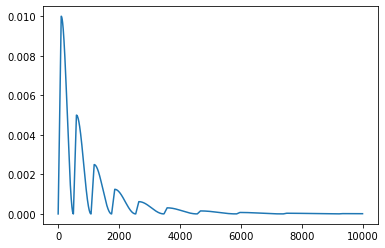

In [32]:
%matplotlib inline

from multi_epoch.utils import CosineAnnealingWarmupRestarts
import matplotlib.pyplot as plt
import torch
import torchvision.models as models

model = models.resnet18()

a = torch.randn((10, 10), requires_grad=True)
b = torch.randn((10, 10), requires_grad=True)
c = a+b

optimizer = torch.optim.Adam(model.parameters())
scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps = 500, cycle_mult = 1.2, max_lr = 0.01, min_lr = 5e-6, warmup_steps = 100, gamma = 0.5)

step = 0
lrs = []

for i in range(10000):
    step += 1
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    
plt.plot(lrs)


In [12]:
import argparse
import wandb
import numpy as np
import pytorch_lightning as pl
import os
from sklearn.model_selection import KFold
from pytorch_lightning.callbacks import LearningRateMonitor
from data_preprocessing.dataloader import data_generator,cross_data_generator,ft_data_generator
from trainer import sleep_ft,sleep_pretrain
from config import Config
#path = "/scratch/SLEEP_data/data_multi/sleepEDF/"
path = "/scratch/SLEEP_data/"
training_mode = 'ss'
config = Config()
def ft_fun(file_name,epoch):
    file_name = file_name+"_epoch"+str(epoch)+'.pt'
    name = os.path.join(config.exp_path,file_name)
    src_path = '/scratch/SLEEP_data/'
    n = cross_data_generator(src_path,[],[],config)
    kfold = KFold(n_splits=5,shuffle=False)
    idxs = np.arange(0,n,1)
    for split,(train_idx,val_idx) in enumerate(kfold.split(idxs)):
        wandb.init(project='delete',group='K-Cross LE',job_type='split: '+str(split),notes='',name=file_name,save_code=True,entity='sleep-staging')
        train_dl,valid_dl= cross_data_generator(src_path,train_idx,val_idx,config)
        le_model = sleep_ft(name,config,train_dl,valid_dl,wandb)
        lr_monitor = LearningRateMonitor(logging_interval='step')
        le_trainer = pl.Trainer(callbacks=[lr_monitor],profiler='simple',enable_checkpointing=False,max_epochs=config.num_ft_epoch,gpus=1)
        wandb.watch([le_model],log='all',log_freq=200)
        le_trainer.fit(le_model)
        wandb.finish(quiet=True)
parser = argparse.ArgumentParser()
parser.add_argument("--file_name", type=str, default="finv1_fusion_intra",
                    help="weights file name")
parser.add_argument("--epoch", type= int, default=20,
                    help="current epoch")
args = parser.parse_args()
ft_fun(args.file_name,int(args.epoch))

NameError: name 'subjects' is not defined

In [ ]:
def cross_data_generator(data_path,train_idxs,val_idxs,configs):
    train_ds = torch.load(os.path.join(data_path, "train.pt"))
    train_ds['samples'] = train_ds['samples'][:,0,:].unsqueeze(1)
    valid_ds = torch.load(os.path.join(data_path, "val.pt"))
    valid_ds['samples'] = valid_ds['samples'][:,0,:].unsqueeze(1)
    train_subs = [48,72,24,30,34,50,38,15,60,12]
    train_segs = [3937, 2161, 3448, 1783, 3083, 2429, 3647, 2714, 3392, 2029]
    val_subs = [23,26,37,44,49,51,54,59,73,82]
    val_segs = [2633, 2577, 2427, 2287, 2141, 2041, 2864, 3071, 4985, 3070]
    segs = train_segs+val_segs
    if train_idxs !=[]:
        dataset = {}
        train_dataset = {}
        valid_dataset = {}
        dataset['samples'] = torch.from_numpy(np.vstack((train_ds['samples'],valid_ds['samples'])))
        dataset['labels'] = torch.from_numpy(np.hstack((train_ds['labels'],valid_ds['labels'])))
        dataset['samples'] = torch.split(dataset['samples'],segs)
        dataset['labels'] = torch.split(dataset['labels'],segs)
        print('Split Shape',len(dataset['samples']))
        train_dataset['samples'] = [dataset['samples'][i] for i in train_idxs]
        train_dataset['labels'] = [dataset['labels'][i] for i in train_idxs]
        dataset['samples'] = torch.cat(dataset['samples'])
        dataset['labels'] = torch.cat(dataset['labels'])
        print('Stack Shape',dataset['samples'].shape,dataset['labels'].shape)
        print('Train Shape',train_dataset['samples'].shape,train_dataset['labels'].shape)
        train_dataset['samples'] = torch.cat(train_dataset['samples'])
        train_dataset['labels'] = torch.cat(train_dataset['labels'])
        print('Train Shape',train_dataset['samples'].shape,train_dataset['labels'].shape)
        train_dataset = Load_Dataset(train_dataset, configs,data_path=data_path,training_mode='ft')
        valid_dataset['samples'] = [dataset['samples'][i] for i in val_idxs]
        valid_dataset['labels'] = [dataset['labels'][i] for i in val_idxs]
        valid_dataset['samples'] = torch.cat(valid_dataset['samples'])
        valid_dataset['labels'] = torch.cat(valid_dataset['labels'])
        valid_dataset = Load_Dataset(valid_dataset,configs,data_path=data_path,training_mode='ft')
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=configs.batch_size,
                                                   shuffle=True, drop_last=configs.drop_last,
                                                   num_workers=10,pin_memory=True,persistent_workers=True)
        valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=configs.batch_size,
                                                   shuffle=False, drop_last=configs.drop_last,
                                                   num_workers=10,pin_memory=True,persistent_workers=True)
        del dataset
        del train_dataset
        del valid_dataset
        return train_loader,valid_loader
    ret = len(val_subs)+len(train_subs)
    del train_ds
    del valid_ds
    return ret